<a href="https://colab.research.google.com/github/Gborgman05/DATA-301-Final-Project/blob/main/Final_Project_with_sections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [ ]:
import pandas as pd
import requests
import numpy as np
import random
from pandas.io.json import json_normalize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
import altair as alt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


# Data Collection and Cleaning 

In [ ]:
# 1st data set we use
df_schools = pd.read_csv("https://raw.githubusercontent.com/Gborgman05/data/main/College_Data.csv")
df_schools.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [ ]:
json_data = requests.get("https://raw.githubusercontent.com/Gborgman05/data/main/schoolInfo.json")
json_data = json_data.json()

In [ ]:
print(len(json_data))
json_data[0].keys()

311


dict_keys(['rankingNoteText', 'nonResponderText', 'nonResponder', 'act-avg', 'primaryPhoto', 'primaryPhotoThumb', 'sat-avg', 'enrollment', 'city', 'sortName', 'zip', 'rankingNoteCharacter', 'acceptance-rate', 'rankingDisplayScore', 'percent-receiving-aid', 'cost-after-aid', 'state', 'rankingSortRank', 'hs-gpa-avg', 'urlName', 'rankingDisplayName', 'rankingDisplayRank', 'ranking', 'xwalkId', 'rankingIsTied', 'isPublic', 'businessRepScore', 'tuition', 'engineeringRepScore', 'displayName', 'schoolType', 'region', 'aliasNames', 'rankingType', 'overallRank', 'institutionalControl', 'rankingMaxPossibleScore', 'rankingRankStatus', 'primaryKey'])

In [ ]:
# 2nd data set we use
df_priv_public = json_normalize(json_data)
df_priv_public.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,rankingNoteText,nonResponderText,nonResponder,act-avg,primaryPhoto,primaryPhotoThumb,sat-avg,enrollment,city,sortName,zip,rankingNoteCharacter,acceptance-rate,rankingDisplayScore,percent-receiving-aid,cost-after-aid,state,rankingSortRank,hs-gpa-avg,urlName,rankingDisplayName,rankingDisplayRank,ranking,xwalkId,rankingIsTied,isPublic,businessRepScore,tuition,engineeringRepScore,displayName,schoolType,region,aliasNames,rankingType,overallRank,institutionalControl,rankingMaxPossibleScore,rankingRankStatus,primaryKey
0,None,None,False,32.0,https://www.usnews.com/img/college-photo_31291...,https://www.usnews.com/img/college-photo_31291...,1400.0,5400.0,Princeton,princetonuniversity,08544,None,7.0,100,60.0,16793.0,NJ,1,3.9,princeton-university,National Universities,#1,overall,186131,False,True,NaN,47140,4.1,Princeton University,national-universities,None,None,national-universities,1,private,None,ranked,2627
1,None,None,False,32.0,https://www.usnews.com/img/college-photo_8866.jpg,https://www.usnews.com/img/college-photo_8866_...,1430.0,6710.0,Cambridge,harvarduniversity,02138,None,5.0,98,55.0,16338.0,MA,2,4.0,harvard-university,National Universities,#2,overall,166027,False,True,NaN,48949,3.6,Harvard University,national-universities,None,None,national-universities,2,private,None,ranked,2155
2,None,None,False,32.0,https://www.usnews.com/dims4/USNEWS/5b128f0/17...,https://www.usnews.com/dims4/USNEWS/196469f/17...,1450.0,5941.0,Chicago,universityofchicago,60637,None,8.0,96,42.0,27767.0,IL,3,4.0,university-of-chicago,National Universities,#3,overall,144050,True,True,NaN,54825,NaN,University of Chicago,national-universities,None,UChicago,national-universities,3,private,None,ranked,1774
3,None,None,False,32.0,https://www.usnews.com/dims4/USNEWS/60348dd/17...,https://www.usnews.com/dims4/USNEWS/1ca230f/17...,1420.0,5472.0,New Haven,yaleuniversity,06520,None,6.0,96,50.0,18385.0,CT,3,NaN,yale-university,National Universities,#3,overall,130794,True,True,NaN,51400,3.4,Yale University,national-universities,None,None,national-universities,3,private,None,ranked,1426
4,None,None,False,32.0,https://www.usnews.com/img/college-photo_19002...,https://www.usnews.com/img/college-photo_19002...,1430.0,6113.0,New York,columbiauniversity,10027,None,6.0,95,48.0,21041.0,NY,5,NaN,columbia-university,National Universities,#5,overall,190150,True,True,NaN,57208,3.8,Columbia University,national-universities,None,None,national-universities,5,private,None,ranked,2707


In [ ]:
# final full data set
df_full = df_priv_public.merge(df_schools, left_on="displayName", right_on="Unnamed: 0")
df_full.head()

,rankingNoteText,nonResponderText,nonResponder,act-avg,primaryPhoto,primaryPhotoThumb,sat-avg,enrollment,city,sortName,zip,rankingNoteCharacter,acceptance-rate,rankingDisplayScore,percent-receiving-aid,cost-after-aid,state,rankingSortRank,hs-gpa-avg,urlName,rankingDisplayName,rankingDisplayRank,ranking,xwalkId,rankingIsTied,isPublic,businessRepScore,tuition,engineeringRepScore,displayName,schoolType,region,aliasNames,rankingType,overallRank,institutionalControl,rankingMaxPossibleScore,rankingRankStatus,primaryKey,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,None,None,False,32.0,https://www.usnews.com/img/college-photo_31291...,https://www.usnews.com/img/college-photo_31291...,1400.0,5400.0,Princeton,princetonuniversity,08544,None,7.0,100,60.0,16793.0,NJ,1,3.9,princeton-university,National Universities,#1,overall,186131,False,True,NaN,47140,4.1,Princeton University,national-universities,None,None,national-universities,1,private,None,ranked,2627,Princeton University,Yes,13218,2042,1153,90,98,4540,146,19900,5910,675,1575,91,96,8.4,54,28320,99
1,None,None,False,32.0,https://www.usnews.com/img/college-photo_8866.jpg,https://www.usnews.com/img/college-photo_8866_...,1430.0,6710.0,Cambridge,harvarduniversity,02138,None,5.0,98,55.0,16338.0,MA,2,4.0,harvard-university,National Universities,#2,overall,166027,False,True,NaN,48949,3.6,Harvard University,national-universities,None,None,national-universities,2,private,None,ranked,2155,Harvard University,Yes,13865,2165,1606,90,100,6862,320,18485,6410,500,1920,97,97,9.9,52,37219,100
2,None,None,False,32.0,https://www.usnews.com/dims4/USNEWS/5b128f0/17...,https://www.usnews.com/dims4/USNEWS/196469f/17...,1450.0,5941.0,Chicago,universityofchicago,60637,None,8.0,96,42.0,27767.0,IL,3,4.0,university-of-chicago,National Universities,#3,overall,144050,True,True,NaN,54825,NaN,University of Chicago,national-universities,None,UChicago,national-universities,3,private,None,ranked,1774,University of Chicago,Yes,6348,2999,922,68,94,3340,39,18930,6380,500,1254,99,99,5.3,36,36854,90
3,None,None,False,32.0,https://www.usnews.com/dims4/USNEWS/60348dd/17...,https://www.usnews.com/dims4/USNEWS/1ca230f/17...,1420.0,5472.0,New Haven,yaleuniversity,06520,None,6.0,96,50.0,18385.0,CT,3,NaN,yale-university,National Universities,#3,overall,130794,True,True,NaN,51400,3.4,Yale University,national-universities,None,None,national-universities,3,private,None,ranked,1426,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99
4,None,None,False,32.0,https://www.usnews.com/img/college-photo_19002...,https://www.usnews.com/img/college-photo_19002...,1430.0,6113.0,New York,columbiauniversity,10027,None,6.0,95,48.0,21041.0,NY,5,NaN,columbia-university,National Universities,#5,overall,190150,True,True,NaN,57208,3.8,Columbia University,national-universities,None,None,national-universities,5,private,None,ranked,2707,Columbia University,Yes,6756,1930,871,78,96,3376,55,18624,6664,550,300,97,98,5.9,21,30639,99


In [ ]:
# columns of data set
df_full.columns

Index(['rankingNoteText', 'nonResponderText', 'nonResponder', 'act-avg',
       'primaryPhoto', 'primaryPhotoThumb', 'sat-avg', 'enrollment', 'city',
       'sortName', 'zip', 'rankingNoteCharacter', 'acceptance-rate',
       'rankingDisplayScore', 'percent-receiving-aid', 'cost-after-aid',
       'state', 'rankingSortRank', 'hs-gpa-avg', 'urlName',
       'rankingDisplayName', 'rankingDisplayRank', 'ranking', 'xwalkId',
       'rankingIsTied', 'isPublic', 'businessRepScore', 'tuition',
       'engineeringRepScore', 'displayName', 'schoolType', 'region',
       'aliasNames', 'rankingType', 'overallRank', 'institutionalControl',
       'rankingMaxPossibleScore', 'rankingRankStatus', 'primaryKey',
       'Unnamed: 0', 'Private', 'Apps', 'Accept', 'Enroll', 'Top10perc',
       'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board',
       'Books', 'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni',
       'Expend', 'Grad.Rate'],
      dtype='object')

In [ ]:
# converts percentages to a decimal
percentages = ["Top10perc", "Top25perc", "perc.alumni", "Grad.Rate", "acceptance-rate"]

for column in percentages:
    df_full[column] = df_full[column] / 100

In [ ]:
# converts the ranks which were read in as categorical because of the # sign, to numerical ranks for analysis
# if the ranking is 231 or above we just assign that observation 231 
df_full["rankingDisplayRank"] = df_full["rankingDisplayRank"].map(lambda a: int(a.replace("#", "")) if "300" not in a else 231 )

In [ ]:
half_count = len(df_full) // 2
df_train = df_full.copy()
df_test = df_train.sample(half_count, random_state=112)
for i in df_test.index:
    df_train = df_train.drop(i)

# Data Exploration

Exploration of variables in relation to our outcome variable of interest, tuition.

## Ranking

Scatterplot:

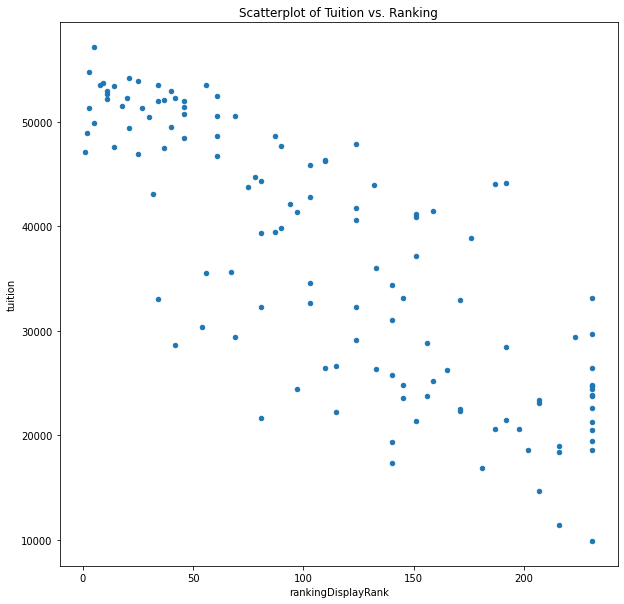

In [ ]:
df_full.plot.scatter(x="rankingDisplayRank", y="tuition",figsize=(10,10), title ="Scatterplot of Tuition vs. Ranking")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["rankingDisplayRank"])

-0.8097964036798709

## Graduation Rate

Scatterplot:

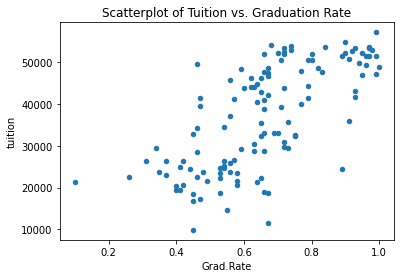

In [ ]:
df_full.plot.scatter(x="Grad.Rate", y="tuition", title ="Scatterplot of Tuition vs. Graduation Rate")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["Grad.Rate"])

0.695669040522532

## Acceptance Rate

Scatterplot:

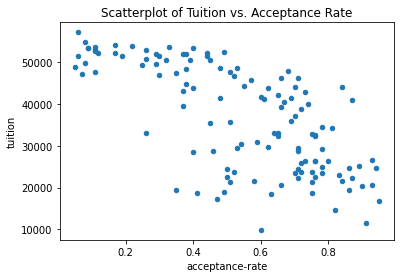

In [ ]:
df_full.plot.scatter(x="acceptance-rate", y="tuition", title ="Scatterplot of Tuition vs. Acceptance Rate")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["acceptance-rate"])

-0.695678820709389

## Top 10% 

Scatterplot:

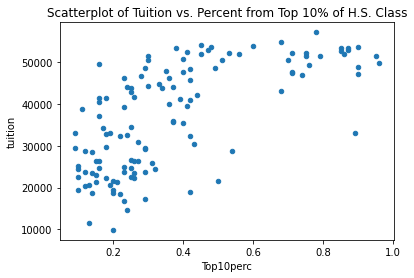

In [ ]:
df_full.plot.scatter(x="Top10perc",y="tuition", title ="Scatterplot of Tuition vs. Percent from Top 10% of H.S. Class")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["Top10perc"])

0.6665815947056888

## Faculty PhD's

Scatterplot:

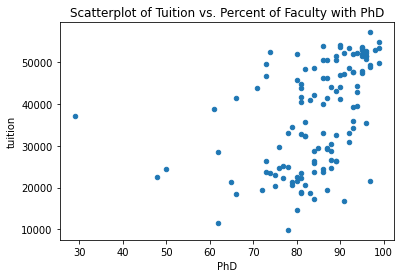

In [ ]:
df_full.plot.scatter(x="PhD", y="tuition", title ="Scatterplot of Tuition vs. Percent of Faculty with PhD")

Correlation:

In [ ]:
df_full["tuition"].corr(df_full["PhD"])

0.4679687360817563

## Student to Faculty Ratio

Scatterplot

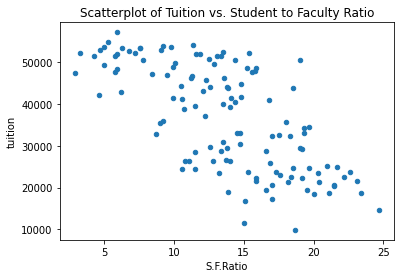

In [ ]:
df_full.plot.scatter(x="S.F.Ratio", y="tuition", title ="Scatterplot of Tuition vs. Student to Faculty Ratio")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["S.F.Ratio"])

-0.6918991327879171

## Engineering Reputation Score

Scatterplot:

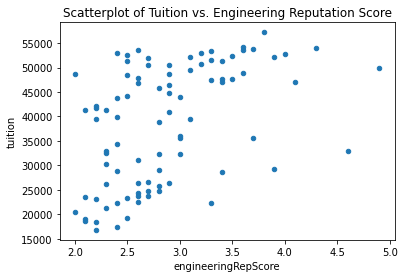

In [ ]:
df_full.plot.scatter(x="engineeringRepScore", y="tuition", title ="Scatterplot of Tuition vs. Engineering Reputation Score")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["engineeringRepScore"])

0.4708187230186716

## Business Reputation Score

Scatterplot:

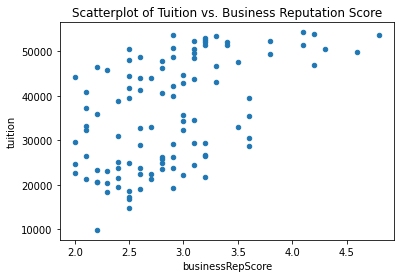

In [ ]:
df_full.plot.scatter(x="businessRepScore", y="tuition", title ="Scatterplot of Tuition vs. Business Reputation Score")

Correlation: 

In [ ]:
df_full["tuition"].corr(df_full["businessRepScore"])

0.5158472090128094

## Public or Private

Bar Graph: 

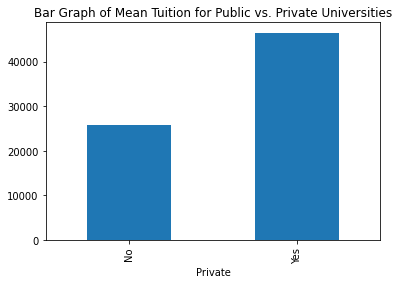

In [ ]:
df_full.groupby("Private")["tuition"].mean().plot.bar(title ="Bar Graph of Mean Tuition for Public vs. Private Universities")

Means: 

In [ ]:
df_full.groupby("Private")["tuition"].mean()

Private
No     25732.948276
Yes    46496.761194
Name: tuition, dtype: float64

# Machine Learning

## Linear Regression

### Full Model

 Full linear regression model with ranking, graduation rate, acceptance rate, percent of incoming students from the top 10% of their high school class, student to faculty ratio, and public or private university as predictors. 

In [ ]:
X_train = df_train[["rankingDisplayRank","Grad.Rate","acceptance-rate","Top10perc","S.F.Ratio","Private"]]
X_test = df_test[["rankingDisplayRank","Grad.Rate","acceptance-rate","Top10perc","S.F.Ratio","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.8566461229504313

### Test Private

In [ ]:
X_train = df_train[["rankingDisplayRank","Grad.Rate","acceptance-rate","Top10perc","S.F.Ratio"]]
X_test = df_test[["rankingDisplayRank","Grad.Rate","acceptance-rate","Top10perc","S.F.Ratio"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]


pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.7059723584581655

R squared value went down, Private is a significant predictor and should be kept.

### Test S.F.Ratio

In [ ]:
X_train = df_train[["rankingDisplayRank","Grad.Rate","acceptance-rate","Top10perc","Private"]]
X_test = df_test[["rankingDisplayRank","Grad.Rate","acceptance-rate","Top10perc","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.8577243956221811

R squared did not change significantly, S.F.Ratio will remain in the final model. 

### Test Top10perc

In [ ]:
X_train = df_train[["rankingDisplayRank","Grad.Rate","acceptance-rate","Private"]]
X_test = df_test[["rankingDisplayRank","Grad.Rate","acceptance-rate","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.865584505376064

R squared went up, Top10perc should be left out of final model. 

### Test acceptance rate

In [ ]:
X_train = df_train[["rankingDisplayRank","Grad.Rate","Private"]]
X_test = df_test[["rankingDisplayRank","Grad.Rate","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.866050997024103

R squared went up slightly, acceptance rate should not remain in the model.

### Test Grad Rate

In [ ]:
X_train = df_train[["rankingDisplayRank","Grad.Rate","Private"]]
X_test = df_test[["rankingDisplayRank","Grad.Rate","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.8668463681412193

R squared went up so Grad rate should not remain in model.

### Test Ranking

In [ ]:
X_train = df_train[["Grad.Rate","acceptance-rate","S.F.Ratio","Private"]]
X_test = df_test[["Grad.Rate","acceptance-rate","S.F.Ratio","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.8284326108691598

R squared went down so ranking is a significant predictor and should remain in the model. 

In [ ]:
def get_r2_scores(features,scoring):
  # define pipeline
  if "Private" in features:
    ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough')
    pipeline = make_pipeline(
      ct,
      StandardScaler(with_mean=False),
      LinearRegression())
  else:
    pipeline = make_pipeline(
        StandardScaler(with_mean=False),
        LinearRegression()
    )
  # calculate highest r2 from cross-validation
  r2_score = cross_val_score(pipeline, X=df_train[features], 
                             y=y_train,
                             scoring=scoring, cv=10)
  # calculate average of the r2 errors
  return r2_score.mean()

# calculate and store errors for different feature sets
scores = pd.Series()
featureList = [["rankingDisplayRank","Grad.Rate"],
                 ["rankingDisplayRank","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate"],
                 ["rankingDisplayRank","acceptance-rate","Private"],
                 ["rankingDisplayRank","Grad.Rate","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate","S.F.Ratio"],
                 ["rankingDisplayRank","acceptance-rate","S.F.Ratio","Private"],
                 ["Grad.Rate","acceptance-rate","S.F.Ratio","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate","S.F.Ratio","Private"]]
for features in [["rankingDisplayRank","Grad.Rate"],
                 ["rankingDisplayRank","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate"],
                 ["rankingDisplayRank","acceptance-rate","Private"],
                 ["rankingDisplayRank","Grad.Rate","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate","S.F.Ratio"],
                 ["rankingDisplayRank","acceptance-rate","S.F.Ratio","Private"],
                 ["Grad.Rate","acceptance-rate","S.F.Ratio","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate","S.F.Ratio","Private"]]:
  scores[str(features)] = get_r2_scores(features,"r2")

scores.sort_values()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['Grad.Rate', 'acceptance-rate', 'S.F.Ratio', 'Private']                         -1.461357
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate']                           -1.211902
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate', 'S.F.Ratio']              -1.113200
['rankingDisplayRank', 'Grad.Rate']                                              -0.408966
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate', 'S.F.Ratio', 'Private']   -0.106740
['rankingDisplayRank', 'Grad.Rate', 'Private']                                   -0.058126
['rankingDisplayRank', 'acceptance-rate', 'S.F.Ratio', 'Private']                 0.015209
['rankingDisplayRank', 'acceptance-rate', 'Private']                              0.058656
['rankingDisplayRank', 'Private']                                                 0.096074
dtype: float64

In [ ]:
err = pd.Series()
for features in featureList:
  err[str(features)] = get_r2_scores(features,"neg_mean_squared_error")
err.sort_values()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate']                           -6.282329e+07
['rankingDisplayRank', 'Grad.Rate']                                              -6.184817e+07
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate', 'S.F.Ratio']              -6.008303e+07
['Grad.Rate', 'acceptance-rate', 'S.F.Ratio', 'Private']                         -5.993916e+07
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate', 'S.F.Ratio', 'Private']   -3.005077e+07
['rankingDisplayRank', 'Grad.Rate', 'Private']                                   -2.702556e+07
['rankingDisplayRank', 'acceptance-rate', 'S.F.Ratio', 'Private']                -2.679725e+07
['rankingDisplayRank', 'acceptance-rate', 'Private']                             -2.562848e+07
['rankingDisplayRank', 'Private']                                                -2.385677e+07
dtype: float64

### Final Linear regression model

In [ ]:
X_train = df_train[["rankingDisplayRank","Private"]]
X_test = df_test[["rankingDisplayRank","Private"]]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linearregression

In [ ]:
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.8669987102944017

In [ ]:
scores = cross_val_score(pipeline, 
                         X=df_full[["rankingDisplayRank","Private"]],
                         y=df_full["tuition"],
                         scoring="r2",
                         cv=4)
scores.mean()

0.6188448628297247

In [ ]:
scores = cross_val_score(pipeline, 
                         X=df_full[["rankingDisplayRank","Private"]],
                         y=df_full["tuition"],
                         scoring="neg_mean_squared_error",
                         cv=4)
np.sqrt(-scores).mean()

4650.184608543036

In [ ]:
# Similar to Cal Poly actual is 23,833
x_new = {'rankingDisplayRank':["137"],'Private':["No"]}
x_new = pd.DataFrame(data=x_new)
pipeline.predict(X=x_new)

array([26471.12970995])

In [ ]:
# Similar to UCLA actual is 44,000
x_new = {'rankingDisplayRank':["20"],'Private':["No"]}
x_new = pd.DataFrame(data=x_new)
pipeline.predict(X=x_new)

array([37607.47063691])

In [ ]:
# Similar to USC actual is 58,000
x_new = {'rankingDisplayRank':["24"],'Private':["Yes"]}
x_new = pd.DataFrame(data=x_new)
pipeline.predict(X=x_new)

array([51599.54635456])

## K means classifier

Find the best features for r2 score


In [ ]:
def get_r2_scores(features,scoring):
  # define pipeline
  if "Private" in features:
    ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough')
    pipeline = make_pipeline(
      ct,
      StandardScaler(with_mean=False),
      LinearRegression())
  else:
    pipeline = make_pipeline(
        StandardScaler(with_mean=False),
        LinearRegression()
    )
  # calculate highest r2 from cross-validation
  r2_score = cross_val_score(pipeline, X=df_train[features], 
                             y=y_train,
                             scoring=scoring, cv=10)
  # calculate average of the r2 errors
  return r2_score.mean()

# calculate and store errors for different feature sets
scores = pd.Series()
featureList = [["rankingDisplayRank","Grad.Rate"],
                 ["rankingDisplayRank","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate"],
                 ["rankingDisplayRank","acceptance-rate","Private"],
                 ["rankingDisplayRank","Grad.Rate","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate","S.F.Ratio"],
                 ["rankingDisplayRank","acceptance-rate","S.F.Ratio","Private"],
                 ["Grad.Rate","acceptance-rate","S.F.Ratio","Private"],
                 ["rankingDisplayRank","Grad.Rate","acceptance-rate","S.F.Ratio","Private"]]
for features in featureList:
  scores[str(features)] = get_r2_scores(features,"r2")

scores.sort_values()

scores = cross_val_score(pipeline, 
                         X=df_full[["rankingDisplayRank","Grad.Rate","S.F.Ratio","Private"]],
                         y=df_full["tuition"],
                         scoring="neg_mean_squared_error",
                         cv=4)
np.sqrt(-scores).mean()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['rankingDisplayRank', 'Grad.Rate']                                              -1.093353
['Grad.Rate', 'acceptance-rate', 'S.F.Ratio', 'Private']                         -1.021336
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate']                           -0.820983
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate', 'S.F.Ratio']              -0.652754
['rankingDisplayRank', 'Grad.Rate', 'acceptance-rate', 'S.F.Ratio', 'Private']   -0.191560
['rankingDisplayRank', 'acceptance-rate', 'S.F.Ratio', 'Private']                -0.161642
['rankingDisplayRank', 'Grad.Rate', 'Private']                                   -0.096871
['rankingDisplayRank', 'Private']                                                -0.082690
['rankingDisplayRank', 'acceptance-rate', 'Private']                             -0.071471
dtype: float64

Find the best K value 


In [ ]:
X_train = df_train[['rankingDisplayRank', 'acceptance-rate', 'Private']  ]
X_test = df_test[['rankingDisplayRank', 'acceptance-rate', 'Private']  ]
y_train = df_train["tuition"]
y_test = df_test["tuition"]

ct = make_column_transformer(
    (OneHotEncoder(), ["Private"]),
    remainder='passthrough'
)
pipeline = make_pipeline(
    ct,
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=3)
)

grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="r2",
                           cv=10)

grid_search.fit(X_train, y_train)
grid_search.best_estimator_


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Private'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregress

In [ ]:
pipeline.fit(X=X_train,y=y_train)
y_pred = pipeline.predict(X=X_test)
r2_score(y_pred, y_test)

0.8564727279289263